# Gabriel's Analysis

## Introduction

The following document contains analysis of cybersecurity data, both adapted from existing code found from the internet and written myself in Python.

The following pre-requisites are required and this block should be run first so that the suitable packages are loaded in.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import StringIO
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt

## Analysis of FTP dataset

FTP stands for File Transfer Protocol. It is a network protocol found in the application layer used to facilitate the transferral of computer files between a client and a server on a network.

We first need to import the dataset (which is in comma seperated value format) from Google Drive to our workspace.

In [86]:
orig_url='https://drive.google.com/file/d/1WemTdLui2MkjG_9ykm2_KPhL1FFfKmiL/view'

file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
ftp_df = pd.read_csv(csv_raw)

We have used the "pandas" package to read the csv into the more easily analysable form of a data frame. Next weperform an initial analysis on the dataframe ftp_df.

In [79]:
#DataFrame with columns
columns = pd.DataFrame(list(ftp_df.columns.values[1:]))

#DataFrame with data types
data_types = pd.DataFrame(ftp_df.dtypes, columns=['Data Type'])

#DataFrame with Count
data_count = pd.DataFrame(ftp_df.count(), columns=['Count'])

#DataFrame with unique values
unique_value_counts = pd.DataFrame(columns=['Unique Values'])
for v in list(ftp_df.columns.values):
    unique_value_counts.loc[v] = [ftp_df[v].nunique()]

missing_data_counts = pd.DataFrame(ftp_df.isnull().sum(), columns=['Missing Values'])
data_quality_report = data_types.join(data_count).join(unique_value_counts).join(missing_data_counts)
print('Data Quality Report')
data_quality_report

Data Quality Report


,Data Type,Count,Unique Values,Missing Values
ts,float64,5796,2390,0
uid,object,5796,137,0
id.orig_h,object,5796,15,0
id.orig_p,int64,5796,95,0
id.resp_h,object,5796,21,0
id.resp_p,int64,5796,1,0
user,object,5796,4,0
password,object,5745,12,51
command,object,5796,6,0
arg,object,2966,1545,2830


To get an impression of what the data looks like, and in doing so check that we have correctly imported the data, we use the head command in order to get a snapshot of the first few terms of our dataframe and see what kind of data is stored in it.

In [70]:
ftp_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,user,password,command,arg,mime_type,file_size,reply_code,reply_msg,passive,orig_h,resp_h,resp_p,fuid
0,1.331904e+09,CNFo204HUpVHDn1qt2,192.168.203.45,34433,192.168.21.101,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,101,219,204).",T,192.168.203.45,192.168.21.101,56268.0,NaN
1,1.331904e+09,CyHkLo2YfhjddpbSVl,192.168.203.45,56158,192.168.21.103,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,103,192,28)",T,192.168.203.45,192.168.21.103,49180.0,NaN
2,1.331904e+09,CotBpLi55vt2fNqm7,192.168.202.96,40138,192.168.28.101,21,<unknown>,NaN,PORT,\x1d\x93!\xf8t\x1ck\xd64\x05\xbb\xbeyu$\x152\x...,NaN,NaN,220.0,ProFTPD 1.3.4rc2 Server (Debian) [::ffff:172.1...,NaN,NaN,NaN,NaN,NaN
3,1.331904e+09,CptK3340W66OKHK3Rd,192.168.202.96,43740,192.168.28.103,21,<unknown>,NaN,PORT,\xbe\xb9wN\x11\xd1\xe1yH\xb8fI\x86\xfdvG\x80\x...,NaN,NaN,530.0,Please log in with USER and PASS first.,NaN,NaN,NaN,NaN,NaN
4,1.331904e+09,C3NlQu4G9w4W3TGSj7,192.168.204.45,50584,192.168.21.101,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,101,163,245).",T,192.168.204.45,192.168.21.101,41973.0,NaN


From looking at the data itself and from experience of looking at similar data from examples we recognize that as this data is logging various connections, the first column should be a timestamp of when each connection is initiated. This makes sense as the first column is labelled ts, obviously short for timestamp, however the data in the table doesn't look much like a timestamp at all. This is due to the way the data has been formatted, however we can use the python package datetime to fix this.

In [91]:
ftp_df["ts"].values[1]
print("This is the format of the ts data before transformation:\n", ftp_df["ts"], "\n\nWith the datatype shown at the bottom.")

This is the format of the ts data before transformation:
 0       1.331904e+09
1       1.331904e+09
2       1.331904e+09
3       1.331904e+09
4       1.331904e+09
            ...     
5791    1.332016e+09
5792    1.332016e+09
5793    1.332016e+09
5794    1.332016e+09
5795    1.332016e+09
Name: ts, Length: 5796, dtype: float64 

With the datatype shown at the bottom.


In [92]:
from datetime import datetime
ftp_df['ts'] = [datetime.fromtimestamp(float(date)) for date in ftp_df['ts'].values]
print("This is the format of the ts data after transformation:\n", ftp_df["ts"], "\n\nWith the datatype shown at the bottom.")

This is the format of the ts data after transformation:
 0      2012-03-16 13:12:38.160
1      2012-03-16 13:12:40.090
2      2012-03-16 13:12:38.950
3      2012-03-16 13:12:41.260
4      2012-03-16 13:25:01.560
                 ...          
5791   2012-03-17 20:21:30.290
5792   2012-03-17 20:21:34.700
5793   2012-03-17 20:21:49.730
5794   2012-03-17 20:21:55.460
5795   2012-03-17 20:22:19.970
Name: ts, Length: 5796, dtype: datetime64[ns] 

With the datatype shown at the bottom.


We now see that by parsing the timestamp column through the above function we now have something readable as a date rather than a long string of numbers, this makes it far nicer for us to read the dataframe. We notice that the data type has changed to a "datetime" format, opposed to the previous "float".

However the readability could still be improved, to do this we will rename the columns to something more user friendly. I have done some research into what each part of the dataframe means and have therefore selected suitable column names accordingly, using the rename() function of the pandas package.

In [158]:
ftp_df.rename(columns = {"ts":"Timestamp","uid":"User ID","id.orig_h":"Originating IP","id.resp_h":"Recieving IP","id.orig_p":"Originating Port","id.resp_p":"Recieving Port"}, inplace = True)
ftp_df.head()

,Timestamp,User ID,Originating IP,Originating Port,Recieving IP,Recieving Port,user,password,command,arg,mime_type,file_size,reply_code,reply_msg,passive,orig_h,resp_h,resp_p,fuid
0,2012-03-16 13:12:38.160,CNFo204HUpVHDn1qt2,192.168.203.45,34433,192.168.21.101,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,101,219,204).",T,192.168.203.45,192.168.21.101,56268.0,NaN
1,2012-03-16 13:12:40.090,CyHkLo2YfhjddpbSVl,192.168.203.45,56158,192.168.21.103,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,103,192,28)",T,192.168.203.45,192.168.21.103,49180.0,NaN
2,2012-03-16 13:12:38.950,CotBpLi55vt2fNqm7,192.168.202.96,40138,192.168.28.101,21,<unknown>,NaN,PORT,\x1d\x93!\xf8t\x1ck\xd64\x05\xbb\xbeyu$\x152\x...,NaN,NaN,220.0,ProFTPD 1.3.4rc2 Server (Debian) [::ffff:172.1...,NaN,NaN,NaN,NaN,NaN
3,2012-03-16 13:12:41.260,CptK3340W66OKHK3Rd,192.168.202.96,43740,192.168.28.103,21,<unknown>,NaN,PORT,\xbe\xb9wN\x11\xd1\xe1yH\xb8fI\x86\xfdvG\x80\x...,NaN,NaN,530.0,Please log in with USER and PASS first.,NaN,NaN,NaN,NaN,NaN
4,2012-03-16 13:25:01.560,C3NlQu4G9w4W3TGSj7,192.168.204.45,50584,192.168.21.101,21,anonymous,IEUser@,PASV,NaN,NaN,NaN,227.0,"Entering Passive Mode (192,168,21,101,163,245).",T,192.168.204.45,192.168.21.101,41973.0,NaN


Now we have made the data more readable, let's use a useful function called describe() to give a nice summary of some of the data.

In [94]:
ftp_df.describe()

,Originating Port,Recieving Port,file_size,reply_code,resp_p
count,5796.000000,5796.0,1.050000e+02,5756.000000,2897.000000
mean,6005.675293,21.0,2.920704e+04,380.597290,46721.828788
std,9053.257962,0.0,2.520387e+05,161.458602,8486.953844
min,1037.000000,21.0,0.000000e+00,200.000000,1054.000000
25%,3885.000000,21.0,2.840000e+02,227.000000,39840.000000
50%,4295.000000,21.0,1.245000e+03,227.000000,46659.000000
75%,4970.000000,21.0,6.286000e+03,550.000000,53991.000000
max,60541.000000,21.0,2.585932e+06,550.000000,61000.000000


An interesting observation I can make at this point is that from our our call to the head function we only saw NaN options for in the file_size column, however according to describe (that provides information about numerical columns) we can see that somewhere in the dataframe entries have value so there must be some data being sent between devices.

### Specific analysis on file_size

We will filter the data by only those rows that have a non NaN filesize i.e. more than 0.

In [114]:
ftp_df_file = ftp_df[ftp_df['file_size'] > 0]
ftp_df_file

,Timestamp,User ID,Originating IP,Originating Port,Recieving IP,Recieving Port,user,password,command,arg,mime_type,file_size,reply_code,reply_msg,passive,orig_h,resp_h,resp_p,fuid
9,2012-03-16 13:37:46.670,CX2CaPOLTnneF2vB3,192.168.24.100,1053,192.168.202.92,21,ftp,password,RETR,ftp://192.168.202.92/./svchost.exe,application/x-dosexec,6656.0,226.0,Transfer complete.,NaN,NaN,NaN,NaN,FyhsRF3Pe3mNtgF8kh
11,2012-03-16 13:40:30.500,Cc63op2xChkQcGt0i1,192.168.27.100,1150,192.168.202.92,21,ftp,password,RETR,ftp://192.168.202.92/./svchost.exe,application/x-dosexec,6656.0,226.0,Transfer complete.,NaN,NaN,NaN,NaN,FJfc4p1bUhOPvW0BWk
5521,2012-03-16 20:48:14.990,CCNcnvTzNNxo2UrW6,192.168.202.94,39218,192.168.25.101,21,anonymous,password,RETR,ftp://192.168.25.101/bash_logout,NaN,220.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,NaN
5523,2012-03-16 20:48:15.030,CCNcnvTzNNxo2UrW6,192.168.202.94,39218,192.168.25.101,21,anonymous,password,RETR,ftp://192.168.25.101/bashrc,text/plain,3353.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,FguByX20C4aW4zuM35
5525,2012-03-16 20:48:15.040,CCNcnvTzNNxo2UrW6,192.168.202.94,39218,192.168.25.101,21,anonymous,password,RETR,ftp://192.168.25.101/profile,NaN,675.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,FguByX20C4aW4zuM35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5750,2012-03-17 13:58:31.040,C9Jq442ff1JhSB0UA8,192.168.202.138,55780,192.168.25.101,21,anonymous,justinwray@justinwray.com,RETR,ftp://192.168.25.101/dept/qdept/registration.py,text/x-python,1833.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,FN0I4S1OOxsdB6296d
5752,2012-03-17 13:58:40.710,C9Jq442ff1JhSB0UA8,192.168.202.138,55780,192.168.25.101,21,anonymous,justinwray@justinwray.com,RETR,ftp://192.168.25.101/dept/qdept/qdept.db,binary,7168.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,FlyBLKuOiUW1CyVD3
5754,2012-03-17 13:58:59.760,C9Jq442ff1JhSB0UA8,192.168.202.138,55780,192.168.25.101,21,anonymous,justinwray@justinwray.com,RETR,ftp://192.168.25.101/dept/qdept/schema.sql,NaN,720.0,226.0,Transfer complete,NaN,NaN,NaN,NaN,FlyBLKuOiUW1CyVD3
5763,2012-03-17 15:00:23.140,Cyu7iq43iCYtaQE8ud,192.168.202.138,56841,192.168.27.101,21,anonymous,anon@lulz.com,RETR,ftp://192.168.27.101/./dept/qdept/qdept.db,binary,7168.0,421.0,No transfer timeout (600 seconds): closing con...,NaN,NaN,NaN,NaN,FhzIDcUNPJqWBMuc5


From the bottom of this sub Dataframe we see that it features 101 rows, which means that out of all of the 5796 entries in the frame only 101 of them show a transferral of data.

It is safe to assume that the numbers in file_size are a representation of bytes, as this is the fundamental measurement of size in computers. If we look back at our describe function from above we see that the maximum file_size = 2.585932e+06 or 2585932. While that may sound large, in bytes that is actually quite a small file in modern computing only representing 2.585932 megabytes, which is about the size of a large png; I have a png on my hardrive that is 2100x2100 pixels that is 2.48 mb.

We see that overall the mean file size sent is about 29kb however if we look at this just on the filtered data (no NaN files) we find:

In [113]:
ftp_df_file.describe()

,Originating Port,Recieving Port,file_size,reply_code,resp_p
count,101.000000,101.0,1.010000e+02,101.000000,0.0
mean,39530.544554,21.0,3.036375e+04,227.930693,NaN
std,10235.699628,0.0,2.569611e+05,19.403225,NaN
min,1053.000000,21.0,2.000000e+00,226.000000,NaN
25%,39226.000000,21.0,2.900000e+02,226.000000,NaN
50%,39226.000000,21.0,1.401000e+03,226.000000,NaN
75%,39226.000000,21.0,6.656000e+03,226.000000,NaN
max,56841.000000,21.0,2.585932e+06,421.000000,NaN


We find that it is slightly larger at 30.36 kb. 

I am now going to plot the size size of file against the time the connection was completed using a scatter graph. Along the bottom of the graph we will see the timestamp in the form of the date (American format) and the hour of the day at which the transfer occured.

(array([734578.625, 734578.75 , 734578.875, 734579.   , 734579.125,
        734579.25 , 734579.375, 734579.5  , 734579.625]),
 <a list of 9 Text major ticklabel objects>)

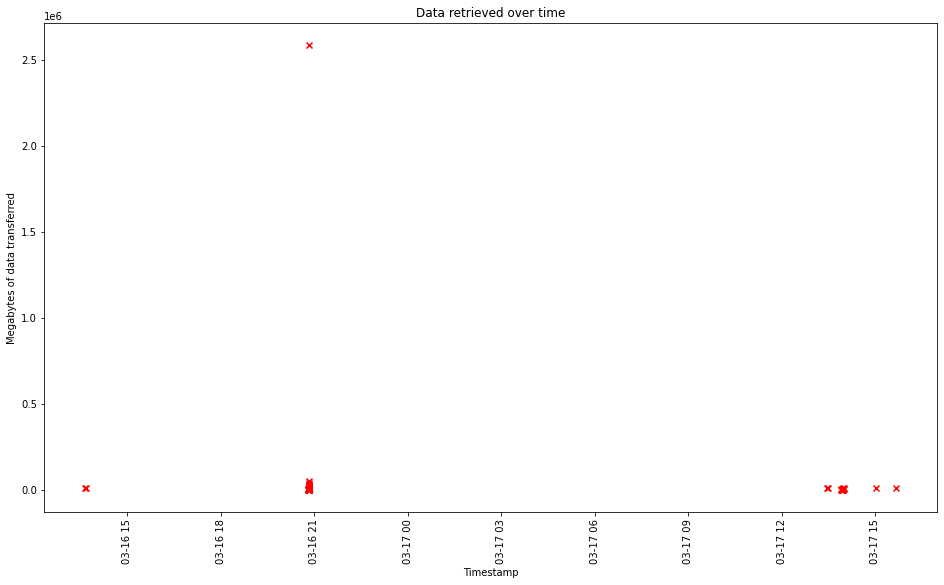

In [200]:
plt.figure(figsize=(16,9))
plt.scatter(ftp_df_file["Timestamp"],ftp_df_file["file_size"],marker ="x",c = "red")
plt.xlabel('Timestamp')
plt.ylabel('Megabytes of data transferred')
plt.title('Data retrieved over time')
plt.xticks(rotation=90)

We see that our maximum value of 2.5 MB is an outlier for most of the data traffic over this period so we will plot another scatter graph that is strictly for the values less than it.

(array([734578.625, 734578.75 , 734578.875, 734579.   , 734579.125,
        734579.25 , 734579.375, 734579.5  , 734579.625]),
 <a list of 9 Text major ticklabel objects>)

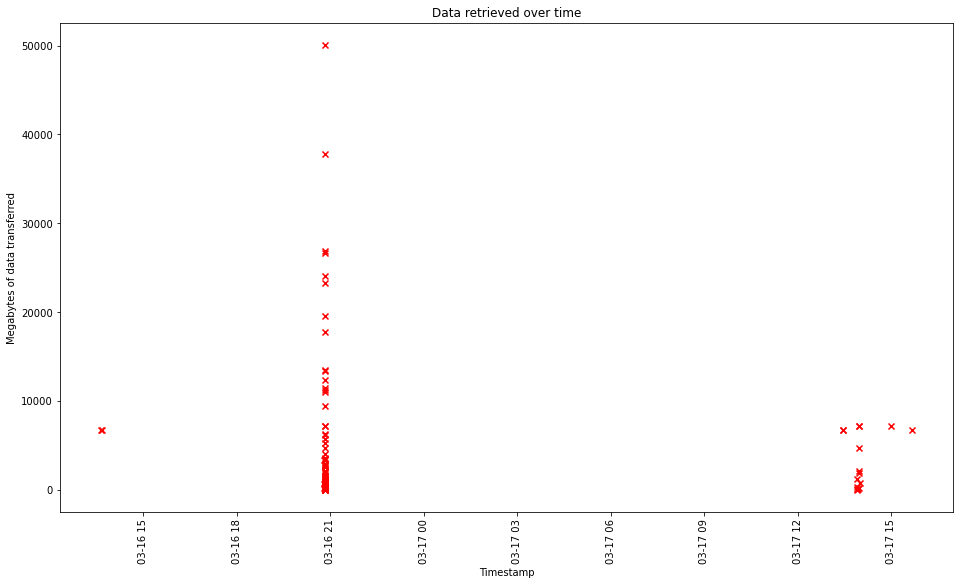

In [201]:
plt.figure(figsize=(16,9))
ftp_df_file2 = ftp_df_file[ftp_df_file['file_size'] < 2.585932e+06]
plt.scatter(ftp_df_file2["Timestamp"],ftp_df_file2["file_size"],marker ="x",c = "red")
plt.xlabel('Timestamp')
plt.ylabel('Megabytes of data transferred')
plt.title('Data retrieved over time')
plt.xticks(rotation=90)

We can see here that despite having 101 seperate transfers as we detailed earlier, they are not consistent transfers spanning the time frame. Most seem to be group around 3 major periods:
* The 16th March at around 13:30
* The 16th March at just before 21:00
* The 17th March approximately around 14:00, but a couple of transfers were seen later at about 15:00 and 16:00.
If we look at our previous plot, we can see that the large download of 2.5 MB was in the second period, just before 21:00.

I'm also interested in looking at the command column of the dataframe to see what are the most common called commands on the FTP protocol. We use the groupby command in order to count the number of each command, then convert this to a dataframe, and then we have to reset the index else we have an extra row. On my first attempt I could not properly name the columns as the index was out and I recieved an error so I had to go back and fix this.

In [141]:
commands = ftp_df.groupby('command').size().sort_values(ascending=False)
commands = pd.DataFrame(commands)
commands.reset_index(level=0, inplace=True)
commands.columns = ['Command','Count']
commands

,Command,Count
0,PASV,2830
1,STOR,1353
2,DELE,1351
3,RETR,112
4,PORT,78
5,APPE,72


Text(0.5, 1.0, 'Number of times each command is used in the FTP Data')

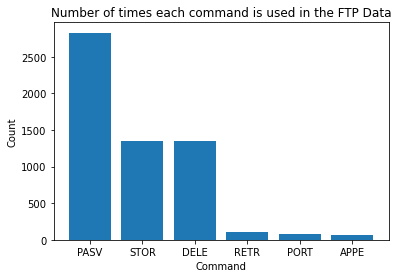

In [144]:
plt.bar(commands["Command"],commands["Count"])
plt.xlabel("Command")
plt.ylabel("Count")
plt.title("Number of times each command is used in the FTP Data")

We see that the command with by far the most usage in the data set is the PASV command. I conducted some research into FTP commands and found that PASV is a "port-defining" command. This means that it specifies which port is used to connect at the client side. PASV itself doesn't take any arguments as it allows the server that is being connected to, to choose a suitable port for itself. The less occurent in our dataset PORT command takes an argument that lets the client specify which port to use.

The other commands are all known as file transfer or management commands and are as follows.

* STOR - used by the client to store files on the server.
* DELE - used to delete a file from a directory.
* RETR - used by the client to retrieve files from the server.
* APPE - used by the client to append data to a file if it already exists or STOR it if not.

If we use the counting protocol above but this time on our sub dataset of values with file_size more than 0 we find:

In [145]:
commands_file = ftp_df_file.groupby('command').size().sort_values(ascending=False)
commands_file = pd.DataFrame(commands_file)
commands_file.reset_index(level=0, inplace=True)
commands_file.columns = ['Command','Count']
commands_file

,Command,Count
0,RETR,101


All of our entries where the file size is more than 0 use the RETR command. It would seem that the file size in this data set is only measured when the client is retrieving data from the server.

## Resources

[Secrepo - source of security data](http://www.secrepo.com/)

[FTP Commands detailed](https://www.educba.com/ftp-commands/)

[ftp.csv dataset (Google Drive Link)](https://drive.google.com/file/d/1WemTdLui2MkjG_9ykm2_KPhL1FFfKmiL/view)

[Stack Overflow resource that helped with downloading files from Google Drive](https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public)